# Predicting Survival Rates Using Data from The Titanic

### Introduction
###### In this project we will be entering into the [Kaggle Titanic](https://www.kaggle.com/c/titanic/) competition.

###### We are provided with two datasets. In both sets are an large array of data of passengers of the famous Titanic cruise ship.

###### In the training set only we are provided with information whether they survived the Titanic sinking (or not).

###### The survival of the test set is withheld by Kaggle, and we can only submit predictions to get a % accuracy (and never the actual results).

###### In this project we will use a wide range of feature engineering and machine learning techniques to submit multiple predictions to see how our scores changes the further we tinker with the data.

> Executive summary:
- Using classification techniques (linear regression, KNN, and random forests) with preprocessing and model selection techniques (minmax scaling, RFECV, GridSearchCV) predictions were entered into Kaggle (of which the true results are never revealed) 
- The accuracy was increased from a position at 40000th to 2300th, with a final accuracy of 78.5%.

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
test = pd.read_csv('titanic_test.csv')
train = pd.read_csv('titanic_train.csv')
print(test.shape, train.shape)

(418, 11) (891, 12)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape

(891, 12)

###### Here breakdown of the columns:

###### PassengerId
> Unique id assigned to each passenger

###### Survival
> 	0 = No, 1 = Yes

###### Pclass
>Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
###### Name
> Full name of passenger
###### Sex
> Male or Female	
###### Age	
> Age in years	
###### Sibsp	
> Number of siblings / spouses aboard the Titanic

> Siblings = brother, sister, stepbrother or stepsister

> Spouse = husband or wife (mistress and fiancés were ignored)
###### Parch
> Number of parents / children aboard the Titanic	
###### Ticket
> Ticket number	
###### Fare	
> Passenger fare
###### Cabin
> Cabin number	
###### Embarked	
> Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
len(train[train['Survived'] == 1])

342

###### 342 passengers survived out of 891 in our training dataset. A survival rate of 38%. 

In [6]:
train.corr()['Survived'].sort_values().drop('Survived')

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

###### Initial correclations suggest that the higher fare you paid and to a lesser extent the more parents you had on board the more likely you were to survive.

###### Conversely the lower class (higher PClass) and older you were the less likely you were to survive.

###### So on first look the most likely person to survive is :
> A young child of high class with a high fare and has many parents aboard.

### Feature Engineering - Categorical Columns:

###### We have just looked at numerical columns. But for machine learning we need all used columns to be numerical.

###### Lets convert the categorical columns to numerical, but first lets preview the unique values for these columns.

In [7]:
categorical_columns = train.columns.drop(train.corr()['Survived'].sort_values().index)
for column in categorical_columns:
    print('Column =', column )
    print ('Unique value count:', len(train[column].unique()))
    print ('Some examples:', train[column].unique()[:5])
    print ('----')

Column = Name
Unique value count: 891
Some examples: ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry']
----
Column = Sex
Unique value count: 2
Some examples: ['male' 'female']
----
Column = Ticket
Unique value count: 681
Some examples: ['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450']
----
Column = Cabin
Unique value count: 148
Some examples: [nan 'C85' 'C123' 'E46' 'G6']
----
Column = Embarked
Unique value count: 4
Some examples: ['S' 'C' 'Q' nan]
----


###### Quick plot of some columns that dont have only a few variables.

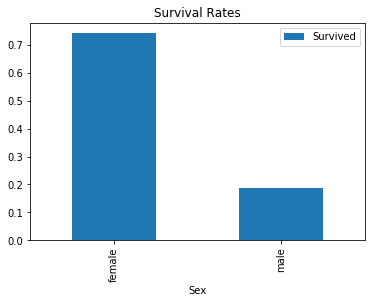

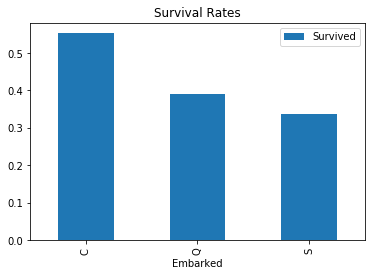

In [8]:
for column in ['Sex', 'Embarked']:
    column_pivot = train.pivot_table(index = column, values = 'Survived', dropna=False).sort_values(by = 'Survived', ascending = False)
    column_pivot.plot.bar()
    plt.xlabel(column)
    plt.title('Survival Rates')
    plt.show()

In [9]:
for column in train.columns:
    null_counts = train[column].isnull().sum()
    print('Column', column, 'has null counts of:', null_counts)

Column PassengerId has null counts of: 0
Column Survived has null counts of: 0
Column Pclass has null counts of: 0
Column Name has null counts of: 0
Column Sex has null counts of: 0
Column Age has null counts of: 177
Column SibSp has null counts of: 0
Column Parch has null counts of: 0
Column Ticket has null counts of: 0
Column Fare has null counts of: 0
Column Cabin has null counts of: 687
Column Embarked has null counts of: 2


###### We will look at these individually and see what feature engineering can be done

### Feature Engineering - Age

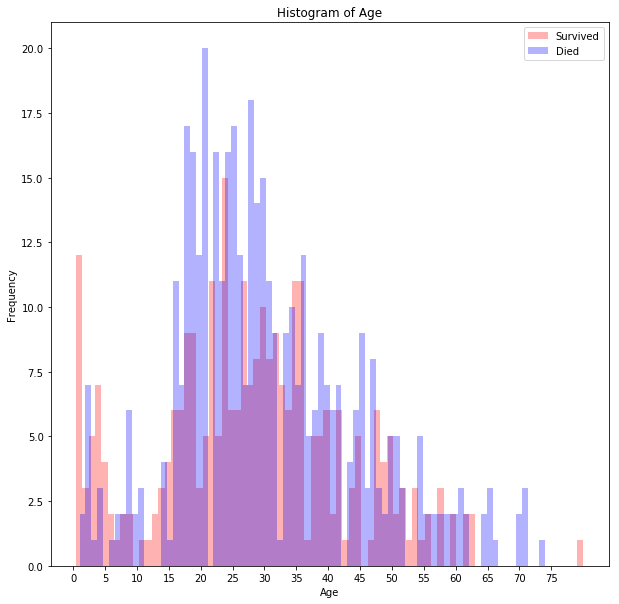

In [10]:
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]
survived['Age'].plot.hist(alpha = 0.3, color = 'red', bins = 80, figsize = (10,10))
died['Age'].plot.hist(alpha = 0.3, color = 'blue', bins= 80, figsize = (10,10))
plt.legend(['Survived', 'Died'])
plt.xticks(np.arange(0, 80, step=5))
plt.xlabel('Age')
plt.title('Histogram of Age')
plt.show()

###### Overlap here is shown in purple. What this graph really highlights is that age 6 or less you are significantly more likely to survive.

In [11]:
under_6_survival = survived[survived['Age'] <= 6]
under_6_dead = died[died['Age'] <= 6]
print('Ratio of survived to died at aged 6 or below:', (len(under_6_survival) / len(under_6_dead)))

Ratio of survived to died at aged 6 or below: 2.357142857142857


###### Compare this to 55 and over.

In [12]:
under_6_survival = survived[survived['Age'] >= 55]
under_6_dead = died[died['Age'] >= 55]
print('Ratio of survived to died at aged 55 or above:', (len(under_6_survival) / len(under_6_dead)))

Ratio of survived to died at aged 55 or above: 0.4482758620689655


###### Our training set has 177 age results (20% of the data) missing.

###### Lets convert the ages into groups as our trend is not linear.
> Infants = 0 to 5

> Child = 5 to 12

> Teenager = 12 to 18

> Young Adult = 18 to 35

> Adult = 35 to 60

> Senior = 60 to 100

> Missing = Missing Data

###### Naturally any such change will be needed to be converted in the training and test sets. 

In [13]:
def process_age(df, cut_points, label_names):
    #Fill in missing data with an age of -0.5 this will make labelling easier#
    df['Age'] = df['Age'].fillna(-0.5)
    df['Age_categories'] = pd.cut(df['Age'], cut_points, labels= label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young_Adult","Adult","Senior"]
train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

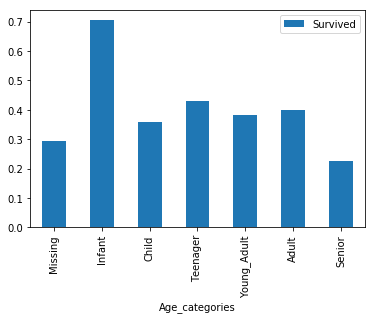

In [14]:
age_pivot = train.pivot_table(index="Age_categories",values='Survived')
age_pivot.plot.bar()
plt.show()

### Feature Engineering - PClass

###### Technically our PClass is already numerical, but we arent quite done. The class here of 1, 2, 3 are ordered but class 2 is not twice as good as class one, there is no ratio (nevermind that class 2 is worse than 1).

###### One simple way to fix this is by one-hot encoding using the pandas get_dummies method. A new column for each class will be created and then a 1 or 0 signifying whether a passenger belongs to that class or not.

In [15]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")

In [16]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_categories,Pclass_1,Pclass_2,Pclass_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Young_Adult,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1,0,0


### Feature Engineering - Sex & Age Categories

###### We will repeat the above for the Embarked, Sex and Age_categories columns

In [17]:
train = create_dummies(train,"Embarked")
test = create_dummies(test,"Embarked")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")

In [18]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_S,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young_Adult,Age_categories_Adult,Age_categories_Senior,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Cabin                         204 non-null object
Embarked                      889 non-null object
Age_categories                891 non-null category
Pclass_1                      891 non-null uint8
Pclass_2                      891 non-null uint8
Pclass_3                      891 non-null uint8
Embarked_C                    891 non-null uint8
Embarked_Q                    891 non-null uint8
E

### Feature Engineering - Cabin

In [20]:
test_cabins = list(test['Cabin'].unique())
for i in train['Cabin'].unique():
    test_cabins.append(i)
unique_cabins = list(set(test_cabins))
print(unique_cabins)

[nan, 'A6', 'B78', 'C106', 'A31', 'E45', 'E58', 'B94', 'F33', 'E68', 'D46', 'C91', 'C148', 'F E46', 'C95', 'B35', 'C2', 'C118', 'B79', 'B96 B98', 'D38', 'D20', 'F', 'E101', 'A16', 'C46', 'B36', 'E24', 'D30', 'A10', 'C87', 'B57 B59 B63 B66', 'A11', 'F38', 'C70', 'A23', 'E63', 'B101', 'A21', 'B28', 'D6', 'B5', 'E36', 'D43', 'E33', 'E12', 'E40', 'B22', 'B69', 'F4', 'B49', 'A7', 'C82', 'E67', 'D47', 'F2', 'E46', 'B45', 'E8', 'C47', 'C123', 'A18', 'E38', 'A19', 'D15', 'C116', 'B41', 'D7', 'D9', 'C132', 'C68', 'B19', 'A14', 'C130', 'E44', 'B24', 'C92', 'D49', 'D21', 'D40', 'C103', 'D56', 'C22 C26', 'C124', 'C28', 'D33', 'C49', 'A36', 'B37', 'C55 C57', 'B26', 'D48', 'E77', 'A5', 'C85', 'C78', 'B4', 'D26', 'B58 B60', 'A34', 'D10 D12', 'C54', 'C110', 'C128', 'B71', 'D35', 'F E69', 'C52', 'B3', 'F G73', 'B80', 'B11', 'A26', 'D34', 'F G63', 'A9', 'E25', 'B39', 'B50', 'G6', 'D17', 'B42', 'A32', 'C39', 'C65', 'F E57', 'A20', 'B86', 'A29', 'C125', 'D28', 'E50', 'E60', 'D36', 'B77', 'D11', 'B38', 'C3

###### Far too many unique values to be useful in machine learning (considering the size of the dataset). But we can see the cabins possess letter prefixes that indicate cabin locations. 

###### Lets capture this information in another column and see the new unique values

In [21]:
train['Cabin_letter'] = train['Cabin'].str[0]
train['Cabin_letter'] = train['Cabin_letter'].fillna('Missing')
train['Cabin_letter'].unique()

array(['Missing', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

###### A far more managable number of variables. 

###### We should also check the test set to see if there are any values we havent detected.

In [22]:
test['Cabin_letter'] = test['Cabin'].str[0]
test['Cabin_letter'] = test['Cabin_letter'].fillna('Missing')
test['Cabin_letter'].unique()

array(['Missing', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

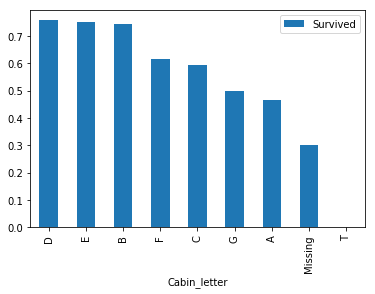

In [23]:
cabin_letter_pivot = train.pivot_table(index = 'Cabin_letter', values = 'Survived', dropna=False).sort_values(by = 'Survived', ascending = False)
cabin_letter_pivot.plot.bar()
plt.show()

In [24]:
train = create_dummies(train,'Cabin_letter')
test = create_dummies(test,'Cabin_letter')

In [25]:
train['Cabin_letter_T'].sum()

1

In [26]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young_Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Sex_female', 'Sex_male', 'Cabin_letter',
       'Cabin_letter_A', 'Cabin_letter_B', 'Cabin_letter_C', 'Cabin_letter_D',
       'Cabin_letter_E', 'Cabin_letter_F', 'Cabin_letter_G',
       'Cabin_letter_Missing'],
      dtype='object')

In [27]:
train[train['Cabin_letter_T'] == 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_letter,Cabin_letter_A,Cabin_letter_B,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_F,Cabin_letter_G,Cabin_letter_Missing,Cabin_letter_T
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,...,T,0,0,0,0,0,0,0,0,1


###### 'Cabin_letter_T' doesnt exist in the test set. As only one value is seen in the training set we can drop this column from the training set and set the 'Cabin_letter_missing' to  = 1

In [28]:
train = train.drop(columns = 'Cabin_letter_T')
train.loc[339]['Cabin_letter_Missing'] = 1
test.isnull().sum()

PassengerId                     0
Pclass                          0
Name                            0
Sex                             0
Age                             0
SibSp                           0
Parch                           0
Ticket                          0
Fare                            1
Cabin                         327
Embarked                        0
Age_categories                  0
Pclass_1                        0
Pclass_2                        0
Pclass_3                        0
Embarked_C                      0
Embarked_Q                      0
Embarked_S                      0
Age_categories_Missing          0
Age_categories_Infant           0
Age_categories_Child            0
Age_categories_Teenager         0
Age_categories_Young_Adult      0
Age_categories_Adult            0
Age_categories_Senior           0
Sex_female                      0
Sex_male                        0
Cabin_letter                    0
Cabin_letter_A                  0
Cabin_letter_B

###### One fare value is missing, we should give this a value.

###### For data with a skewed distribution, mean is not suitable. We shall use the median from the training data to impute the new value.

In [29]:
train['Fare'].median()

14.4542

In [30]:
test['Fare'].iloc[152] = train['Fare'].median()

###### Lets drop the columns that are too varied to be of use (at least for now) - PassengerId, Name, Ticket

###### Lets also drop the original columns for which we created dummy categories for - Age, Age_categories, Cabin, Cabin_letter, Pclass, Embarked, Sex to create our feature columns

###### And of course drop the Survived category from our feature list as we cant use this for predictions!

In [31]:
feature_columns = train.columns.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_letter', 'Age', 'Age_categories', 'Pclass', 'Embarked', 'Sex', 'Survived'])

### Logistical Regression

###### First a benchmark accuracy seeing how well the training set predicts the training set.

In [32]:
benchmark_lr = LogisticRegression()
benchmark_lr.fit(train[feature_columns], train['Survived'])
benchmark_lr_predictions = benchmark_lr.predict(train[feature_columns])
print(accuracy_score(train['Survived'], benchmark_lr_predictions))

0.8260381593714927


###### Determine with K-Fold validation on the training set to predict (sections of) the training set

In [33]:
kfold_lr = LogisticRegression()
scores = cross_val_score(kfold_lr, train[feature_columns] , train['Survived'], cv=10)
accuracy = np.mean(scores)
print('Scores:', scores)
print('---')
print('Overall Accuracy:', accuracy)

Scores: [0.8        0.81111111 0.78651685 0.84269663 0.78651685 0.79775281
 0.78651685 0.79775281 0.85393258 0.82954545]
---
Overall Accuracy: 0.8092341958914993


###### Next lets generate the predictions on the test set.

###### Then submit it to [Kaggle](https://www.kaggle.com/c/titanic/leaderboard) for our results.

In [34]:
lr = LogisticRegression()
lr.fit(train[feature_columns], train['Survived'])
lr_predictions = lr.predict(test[feature_columns])

In [35]:
def submit_results_to_csv(predictions, csv_name):
    ids = test['PassengerId']
    submission_df = {"PassengerId": ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(csv_name, index = False)

In [36]:
submit_results_to_csv(lr_predictions, 'submission_1.csv')

###### Our score was 0.775, or 78% accuracy. Pretty good.

###### This puts us as postion of ~40k out of 50k.

###### Lets see if we can improve it.

In [37]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young_Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Sex_female', 'Sex_male', 'Cabin_letter',
       'Cabin_letter_A', 'Cabin_letter_B', 'Cabin_letter_C', 'Cabin_letter_D',
       'Cabin_letter_E', 'Cabin_letter_F', 'Cabin_letter_G',
       'Cabin_letter_Missing'],
      dtype='object')

In [38]:
train.sort_values(by ='Ticket')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_male,Cabin_letter,Cabin_letter_A,Cabin_letter_B,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_F,Cabin_letter_G,Cabin_letter_Missing
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,...,0,B,0,1,0,0,0,0,0,0
257,258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,...,0,B,0,1,0,0,0,0,0,0
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,...,0,B,0,1,0,0,0,0,0,0
262,263,0,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.6500,...,1,E,0,0,0,0,1,0,0,0
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,...,0,E,0,0,0,0,1,0,0,0
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,...,0,E,0,0,0,0,1,0,0,0
110,111,0,1,"Porter, Mr. Walter Chamberlain",male,47.0,0,0,110465,52.0000,...,1,C,0,0,1,0,0,0,0,0
475,476,0,1,"Clifford, Mr. George Quincy",male,-0.5,0,0,110465,52.0000,...,1,A,1,0,0,0,0,0,0,0
430,431,1,1,"Bjornstrom-Steffansson, Mr. Mauritz Hakan",male,28.0,0,0,110564,26.5500,...,1,C,0,0,1,0,0,0,0,0
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.0,1,0,110813,75.2500,...,0,D,0,0,0,1,0,0,0,0


In [39]:
train.groupby('Ticket').count()['Survived'].sort_values(ascending = False)

Ticket
CA. 2343         7
1601             7
347082           7
347088           6
CA 2144          6
3101295          6
S.O.C. 14879     5
382652           5
2666             4
19950            4
PC 17757         4
17421            4
347077           4
349909           4
113760           4
LINE             4
W./C. 6608       4
113781           4
4133             4
248727           3
SC/Paris 2123    3
C.A. 31921       3
29106            3
PC 17760         3
F.C.C. 13529     3
PC 17582         3
PC 17755         3
363291           3
345773           3
371110           3
                ..
349205           1
349206           1
349207           1
349208           1
349209           1
349210           1
349212           1
349213           1
349214           1
349215           1
349216           1
349217           1
349218           1
349221           1
349242           1
349222           1
349223           1
349224           1
349225           1
349227           1
349228           1
34923

In [40]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
print(train[columns].describe(include='all'))

             SibSp       Parch        Fare        Cabin Embarked
count   891.000000  891.000000  891.000000          204      889
unique         NaN         NaN         NaN          147        3
top            NaN         NaN         NaN  C23 C25 C27        S
freq           NaN         NaN         NaN            4      644
mean      0.523008    0.381594   32.204208          NaN      NaN
std       1.102743    0.806057   49.693429          NaN      NaN
min       0.000000    0.000000    0.000000          NaN      NaN
25%       0.000000    0.000000    7.910400          NaN      NaN
50%       0.000000    0.000000   14.454200          NaN      NaN
75%       1.000000    0.000000   31.000000          NaN      NaN
max       8.000000    6.000000  512.329200          NaN      NaN


In [41]:
train.isnull().sum()

PassengerId                     0
Survived                        0
Pclass                          0
Name                            0
Sex                             0
Age                             0
SibSp                           0
Parch                           0
Ticket                          0
Fare                            0
Cabin                         687
Embarked                        2
Age_categories                  0
Pclass_1                        0
Pclass_2                        0
Pclass_3                        0
Embarked_C                      0
Embarked_Q                      0
Embarked_S                      0
Age_categories_Missing          0
Age_categories_Infant           0
Age_categories_Child            0
Age_categories_Teenager         0
Age_categories_Young_Adult      0
Age_categories_Adult            0
Age_categories_Senior           0
Sex_female                      0
Sex_male                        0
Cabin_letter                    0
Cabin_letter_A

###### Fill in the missing embarked columns as the most common embarked ('S') and update our dummies

In [42]:
train[train['Embarked'].isnull()]['Embarked_S'] = 1
train['Embarked']= train['Embarked'].fillna('S')
test[test['Embarked'].isnull()]['Embarked_S'] = 1
test['Embarked'] =test['Embarked'].fillna('S')

### Feature Engineering - Scale

###### SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512.

###### Scaling will reduce the impact of a wide variation in Fare

In [43]:
for column in ['SibSp', 'Parch','Fare']:
    train[column + '_scaled'] = minmax_scale(train[column])
    test[column + '_scaled'] = minmax_scale(test[column])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [44]:
train[['SibSp_scaled', 'Parch_scaled', 'Fare_scaled']].describe()

,SibSp_scaled,Parch_scaled,Fare_scaled
count,891.000000,891.000000,891.000000
mean,0.065376,0.063599,0.062858
std,0.137843,0.134343,0.096995
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.015440
50%,0.000000,0.000000,0.028213
75%,0.125000,0.000000,0.060508
max,1.000000,1.000000,1.000000


### Feature Importance

###### Lets now see what features are important in this logistical regression

In [45]:
feature_columns = train.columns.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_letter', 'Age', 'Age_categories', 'Pclass', 'Embarked', 'Sex', 'Survived', 'Fare', 'Parch', 'SibSp'])
feature_columns

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young_Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Sex_female', 'Sex_male', 'Cabin_letter_A',
       'Cabin_letter_B', 'Cabin_letter_C', 'Cabin_letter_D', 'Cabin_letter_E',
       'Cabin_letter_F', 'Cabin_letter_G', 'Cabin_letter_Missing',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled'],
      dtype='object')

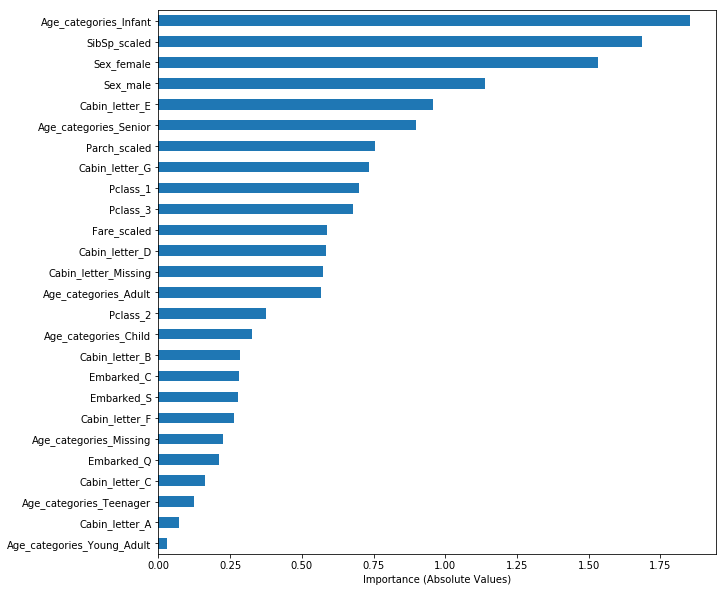

In [46]:
importance_lr = LogisticRegression()
importance_lr.fit(train[feature_columns], train['Survived'])
importance_coefficients = importance_lr.coef_
importance_series = pd.Series(importance_coefficients[0], index = feature_columns)
importance_series = importance_series.abs().sort_values()
importance_series.plot.barh(figsize = (10,10))
plt.xlabel('Importance (Absolute Values)')
plt.show()

In [47]:
importance_series[-10:].index

Index(['Pclass_3', 'Pclass_1', 'Cabin_letter_G', 'Parch_scaled',
       'Age_categories_Senior', 'Cabin_letter_E', 'Sex_male', 'Sex_female',
       'SibSp_scaled', 'Age_categories_Infant'],
      dtype='object')

###### Now using this list lets see more feature columns affects the accuracy

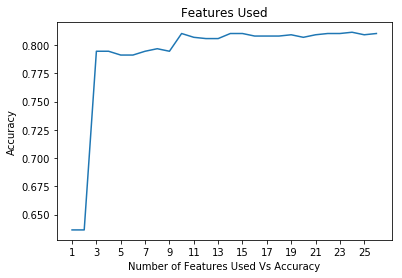

In [48]:
top_accuracies = []
top_importance_lr = LogisticRegression()
for i in range(1,(len(importance_series)+1)):
    scores = cross_val_score(top_importance_lr, train[importance_series[-i:].index], train['Survived'])
    top_accuracies.append(np.mean(scores))

plt.plot(np.arange(1,(len(importance_series)+1)),top_accuracies)
plt.xlabel('Number of Features Used Vs Accuracy')
plt.ylabel('Accuracy')
plt.title('Features Used')
plt.xticks(np.arange(1,(len(importance_series)+1),2))
plt.show()

In [49]:
print('Accuracy with 3 features = ', top_accuracies[2])
print('Accuracy with 10 features = ', top_accuracies[9])

Accuracy with 3 features =  0.7946127946127945
Accuracy with 10 features =  0.8103254769921437


###### Biggest jump is from 2 to 3 features. Then from 9 to 10 features. After this the returns are diminishing. 

###### Compared to our earlier cross val score of 0.809 the improvement has not been significant.

### Feature Engineering Fare
###### We have tried scaling this column.

###### Another approach is to use bins to group values, lets see how suitable this is. 

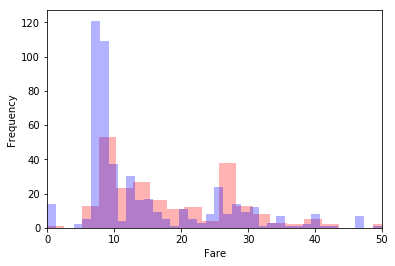

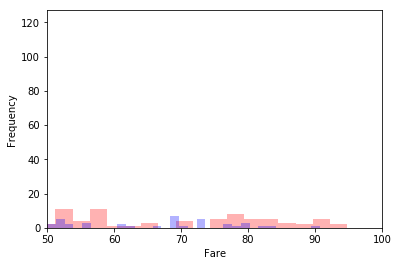

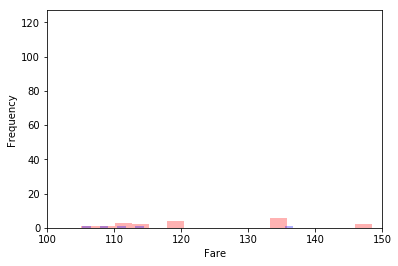

In [50]:
for i in range(0,150,50):
    survived['Fare'].plot.hist(alpha=0.3, color = 'red', bins = 200)
    died['Fare'].plot.hist(alpha=0.3, color = 'blue', bins = 200)
    plt.xlim(left = i, right = (i+ 50))
    plt.xlabel('Fare')
    plt.show()

###### There does seems to be some good groupings based on the price. So lets proceed with the binning:

###### Set groupings as:
> 0 to <10

> 10 to <50

> 50 to 100

> 100 to 1000

In [51]:
groupings = [0,10,50,100,1000]
for i in range(0,4):
    survival_ratio = len(survived[survived['Fare'].between(groupings[i],groupings[i+1])]) / len(died[died['Fare'].between(groupings[i],groupings[i+1])])
    print('Survival ratio between', groupings[i], 'and', groupings[(i+1)], 'is:', survival_ratio)  

Survival ratio between 0 and 10 is: 0.24907063197026022
Survival ratio between 10 and 50 is: 0.7248908296943232
Survival ratio between 50 and 100 is: 1.8421052631578947
Survival ratio between 100 and 1000 is: 2.7857142857142856


###### Now we will group these accordingly. Any null values will be considered -0.5.

In [52]:
def process_fare(df,cut_points,label_names):
    df["Fare"] = df["Fare"].fillna(-0.5)
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

In [53]:
fare_cut_points = [-1, 10, 50, 100, 1000]
fare_category_labels = ['0-10', '10-50', '50-100', '100+']
train = process_fare(train, fare_cut_points, fare_category_labels)
test = process_fare(test, fare_cut_points, fare_category_labels)
train = create_dummies(train,"Fare_categories")
test = create_dummies(test,"Fare_categories")

### Feature Engineering - Name

###### On further examination we can gleam some information from the names. They are not as unique as they first appear.

###### Here we see the Countess, Rev and Col prefixes multiple times:

In [54]:
train[train['Name'].str.contains('Countess\.') | train['Name'].str.contains('Rev\.') | train['Name'].str.contains('Col\.')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_letter_G,Cabin_letter_Missing,SibSp_scaled,Parch_scaled,Fare_scaled,Fare_categories,Fare_categories_0-10,Fare_categories_10-50,Fare_categories_50-100,Fare_categories_100+
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.000,...,0,1,0.000,0.000000,0.025374,10-50,0,1,0,0
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.525,...,0,1,0.000,0.000000,0.024447,10-50,0,1,0,0
249,250,0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.000,...,0,1,0.125,0.000000,0.050749,10-50,0,1,0,0
626,627,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,219533,12.350,...,0,1,0.000,0.000000,0.024106,10-50,0,1,0,0
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.500,...,0,0,0.000,0.000000,0.069291,10-50,0,1,0,0
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.550,...,0,1,0.000,0.000000,0.051822,10-50,0,1,0,0
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.500,...,0,0,0.000,0.000000,0.168837,50-100,0,0,1,0
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.000,...,0,1,0.000,0.166667,0.064412,10-50,0,1,0,0
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,...,0,1,0.000,0.000000,0.025374,10-50,0,1,0,0


###### We will use regular expression to capture all the instances of the name variations.

In [55]:
#Use regular expression to capture the groups that end with a fullstop in the names#
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
print(extracted_titles.value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Lady          1
Capt          1
Sir           1
Don           1
Mme           1
Ms            1
Countess      1
Name: Name, dtype: int64


###### Now using a dictionary we can codify these into groups of:
> Mr, Mrs, Master, Miss, Officer and Royalty

In [56]:
titles_dict = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}
train['Title'] = extracted_titles.map(titles_dict)
extracted_titles_test = test["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
test['Title'] = extracted_titles_test.map(titles_dict)

###### Create dummy columns from this

In [57]:
train = create_dummies(train,'Title')
test = create_dummies(test,'Title')

### Feature Engineering Collinearity

###### We now have a very large number of features. This is not inherently bad in that they could all be very important, however it is a sure sign we should check for when these are correlating with each other and maybe be representing the same thing.

###### This is extremely prominent in the [dummy variable trap](http://www.algosome.com/articles/dummy-variable-trap-regression.html) which is a condition that arises from our use of dummy categories.

###### For instance having a column of Sex_female with 1's and 0's is also really displaying Sex_males at the same time as a 1 is female and a 0 is male. In the model this will essentially assign double the importance than it should

In [58]:
def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    #np.zeros_like = create an array of zeros to match that of the correlation#
    mask = np.zeros_like(corr, dtype=np.bool)
    #triu_indices_from = return the indices of the upper right triangle of an array#
    #Then apply the zeros using this mask and triangle#
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

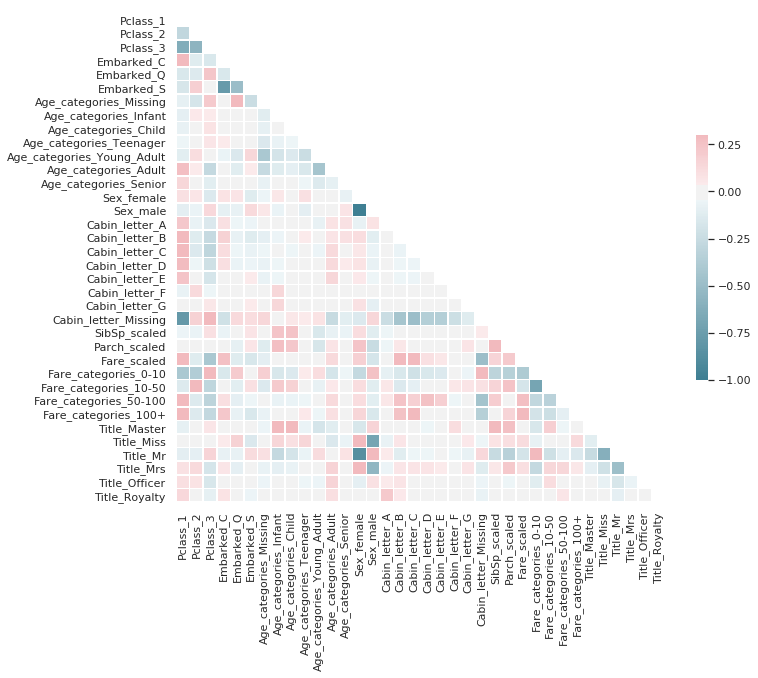

In [59]:
feature_columns = train.columns.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_letter', 'Age', 'Age_categories', 'Pclass', 'Embarked', 'Sex', 'Survived', 'Fare', 'Parch', 'SibSp', 'Fare_categories', 'Title'])
plot_correlation_heatmap(train[feature_columns])

###### We can see many features are strongly  correlated between :
> The Sex variables with many of the Titles
###### We should remove the sex columns as titles appear to be more nuanced.

###### We should also remove one of the dummy variables from each type to reduce collinearity in each type. We will remove
> 'Pclass_2', 'Age_categories_Teenager', 'Fare_categories_10-50', 'Title_Master', 'Cabin_type_A'

In [60]:
feature_columns = train.columns.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Cabin_letter', 'Age', 'Age_categories', 'Pclass', 'Embarked', 'Sex', 'Survived', 'Fare', 'Parch', 'SibSp', 'Fare_categories', 'Title', 'Pclass_2', 'Age_categories_Teenager', 'Fare_categories_10-50', 'Title_Master', 'Cabin_letter_A'])


### Feature Engineering - Recursive Feature Elimination

###### Earlier we looked at feature importance manually, one automated way is to use the RFECV (recursive feature elimination cross validation) to select the most relevant features.

In [61]:
RFECV_lr = LogisticRegression()
RFECV_selector = RFECV(lr, cv=10)
RFECV_selector.fit(train[feature_columns], train['Survived'])
#The .support_ gives a True / False boolean mask of best features#

RFECV(cv=10,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

In [62]:
optimised_columns = train[feature_columns].columns[RFECV_selector.support_]
optimised_columns

Index(['Pclass_3', 'Embarked_C', 'Age_categories_Infant',
       'Age_categories_Adult', 'Age_categories_Senior', 'Sex_female',
       'Cabin_letter_D', 'Cabin_letter_E', 'Cabin_letter_G',
       'Cabin_letter_Missing', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled',
       'Fare_categories_50-100', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royalty'],
      dtype='object')

In [63]:
len(feature_columns)

31

In [64]:
len(optimised_columns)

18

###### Our feature columns have been reduced by 42% to 18 columns

###### Lets see what this has done to our cross validation accuracy

In [65]:
rfecv_lr = LogisticRegression()
rfecv_scores = cross_val_score(rfecv_lr, train[optimised_columns], train['Survived'], cv = 10)
rfecv_accuracy = np.mean(rfecv_scores)
print(rfecv_accuracy)

0.8261264328680058


###### Previously our accuracies were 0.80, 0.81. Now we have 0.83. Improvements are making small differences.

###### Time to test it on Kaggle

In [66]:
lr_2 = LogisticRegression()
lr_2.fit(train[optimised_columns], train['Survived'])
lr_2_predictions = lr_2.predict(test[optimised_columns])
submit_results_to_csv(lr_2_predictions, 'submission_2.csv')

###### Our score was 0.767 a slight drop from previous. 

###### This is a big suggestion to try another method.

### K-Nearest Neighbours Classifier

###### Lets now try classification using the K Nearest Neighbours method.

In [67]:
KNN_baseline = KNeighborsClassifier()
KNN_baseline.fit(train[feature_columns], train['Survived'])
KNN_baseline_predictions = KNN_baseline.predict(train[feature_columns])
accuracy_score(train['Survived'], KNN_baseline_predictions)

0.8619528619528619

###### Base line is marginally higher than logistical regression.

In [68]:
KNN_scores = cross_val_score(KNN_baseline, train[feature_columns], train['Survived'], cv=10)
print(np.mean(KNN_scores))

0.8148518896833503


###### Cross validation score is significantly lower suggests baseline was overfitting.

###### Lets see the effect of varying the number of neigbours (also known as a grid search)

In [69]:
knn_scores = dict()
for n_neigbour in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors = n_neigbour)
    scores = cross_val_score(knn, train[feature_columns], train['Survived'], cv= 10)
    mean = np.mean(scores)
    knn_scores[n_neigbour] = mean

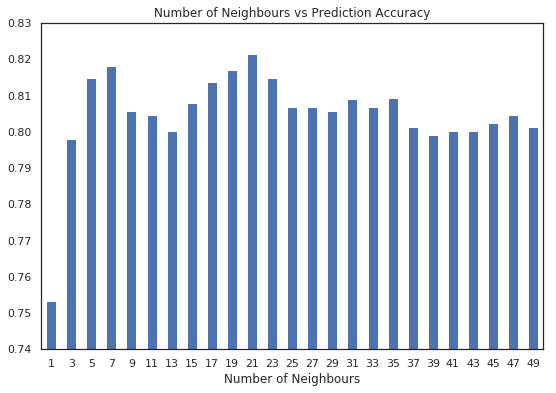

In [70]:
pd.Series(knn_scores).plot.bar(figsize = (9,6), ylim = (0.74, 0.83), rot = 0)
plt.xlabel('Number of Neighbours')
plt.title('Number of Neighbours vs Prediction Accuracy')
plt.show()

###### 21 nearest Neighbours is giving us the best score

###### Lets perform a more extensive grid search and cross validation

###### We can cycle through:
> Number of neighbours

> The available weightings

> The available algorithms

> The available power term (for Minkowski vs Euclidean metrics)

###### Naturally this takes some time...

In [71]:
knn = KNeighborsClassifier()
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['ball_tree', 'kd_tree', 'brute'],
    "p": [1,2]
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(train[feature_columns], train['Survived'])
print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
0.8204264870931538


###### Using these best features lets submit our predictions.

In [72]:
best_knn = grid.best_estimator_
knn_predictions = best_knn.predict(test[feature_columns])
submit_results_to_csv(knn_predictions, 'submission_3.csv')

###### We have jumped from 0.77511 to 0.78468 this puts us at position 2300 out of 50k, very impressive (especially considering all the predictions of 100% cheaters.

### Random Forests Classifier

###### We will try one final classifier of the random forests (an ensemble of multiple decision tree classifiers)

In [73]:
rfc = RandomForestClassifier(random_state = 1)
rfc_hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
                      }
rfc_grid = GridSearchCV(rfc, param_grid= rfc_hyperparameters, cv = 10)
grid.fit(train[feature_columns], train['Survived'])

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 20, 2), 'weights': ['distance', 'uniform'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
0.8204264870931538


In [75]:
best_rcf = grid.best_estimator_
rcf_predictions = best_rcf.predict(test[feature_columns])
submit_results_to_csv(rcf_predictions, 'submission_4.csv')

###### Interestingly we achieved the same score of 0.78468

###### Lets check which values match

In [76]:
knn_predictions == rcf_predictions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

###### Both methods are giving not only the same percentage predictions, but are actually the same exact predictions!

###### In this project we have demonstrated a wide range of feature engineering and machine learning to enter the Kaggle competition and successfuly boost the postion by ~38k places.